# Spatial mapping of cell types across the mouse brain (1/3) - estimating reference expression signatures of cell types

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3)


## Loading packages

First, we need to load the relevant packages. Regression model for estimating expression signatures of cell types cell2location is written in pytorch. While the package works on both GPU and CPU, using the GPU shortens the computation time by ~8 times to just a few minutes.

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

In [2]:
import cell2location

In [3]:
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

The snRNAseq of the aging mouse hypothalamus has around 40k nuclei. We have eight female mice with four 3m old young mice and four 24m old aged mice. 

In [19]:
sc_data_folder = './data/'
results_folder = './results/mouse_brain_snrna/'

In [21]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad("./data/mouse_brain_visium_wo_cloupe_data/hypo_all_RNA.h5ad")

## Cell type annotations
labels = pd.read_csv('all_meta_20210816.csv', index_col=0)

In [22]:
adata_snrna_raw.obs = labels
adata_snrna_raw.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,percent.mt,integrated_snn_res.1.5,seurat_clusters,group,major_group
Unnamed: 0,,,,,,,,,
AAACCTGAGACTAGAT-1_1,Aged_1,5452,2747,Aged,0.752018,46,46,Avp/Oxt,Neuron
AAACCTGAGGCCCGTT-1_1,Aged_1,2100,1163,Aged,0.666667,32,32,Nrg1/Nnat,Neuron
AAACCTGAGTAAGTAC-1_1,Aged_1,1265,821,Aged,4.505929,3,3,Oligodendrocyte,Oligodendrocyte
AAACCTGAGTGAACGC-1_1,Aged_1,1810,1219,Aged,4.309392,11,11,OPC,OPC
AAACCTGAGTGGCACA-1_1,Aged_1,759,554,Aged,7.905138,0,0,Oligodendrocyte,Oligodendrocyte
...,...,...,...,...,...,...,...,...,...
TTTGTTGGTAGGCAAC-1_8,Young_4,18262,5312,Young,0.520206,10,10,Rnf220/Ntng1,Neuron
TTTGTTGGTGCGCTCA-1_8,Young_4,2539,1677,Young,0.236314,21,21,Sst/Npy,Neuron
TTTGTTGTCACAGTGT-1_8,Young_4,9571,3730,Young,0.031345,1,1,Trh/Gpc5,Neuron


Add cell type labels as columns in `adata.obs`

In [23]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 40064 × 25135
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'percent.mt', 'integrated_snn_res.1.5', 'seurat_clusters', 'group', 'major_group'
    var: 'features'
    obsm: 'X_umap'

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

"Two cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations:

1. Include all genes expressed by at least 3% of cells (`cell_count_cutoff2`)
2. Include genes expressed by at least 0.05% of cells (`cell_count_cutoff`) when they have high counts in non-zero cells (`nonz_mean_cutoff`)

We prefer this way of selecting genes because step 2 allows retaining genes expressed by rare cell populations but at high levels, whereas standard HVG selection methods can filter out such genes due to their low global mean and variance." -- **cell2location** notebook

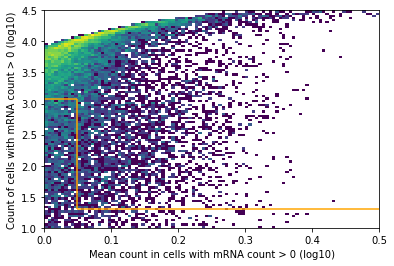

In [24]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

Show the number of selected cells and genes:

In [25]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(40064, 14795)

Filter the object:

In [26]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

Add counts matrix as `adata.raw` 

In [27]:
adata_snrna_raw.raw = adata_snrna_raw

## 3. Show UMAP of cells <a name="3.-Show-UMAP-of-cells"></a>

We can examine the cell composition of our data by using a standard scanpy workflow to generate a UMAP representation of the single cell data.

In [28]:
#########################
adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()
sc.pp.log1p(adata_snrna_raw)

sc.pp.scale(adata_snrna_raw, max_value=10)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=80, use_highly_variable=False)

# Plot total counts over PC to check whether PC is indeed associated with total counts
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw.obsm['X_pca'] = adata_snrna_raw.obsm['X_pca'][:, 1:]
adata_snrna_raw.varm['PCs'] = adata_snrna_raw.varm['PCs'][:, 1:]
#########################



In [29]:
# Here BBKNN (https://github.com/Teichlab/bbknn) is used to align batches (10X experiments) 
import bbknn
bbknn.bbknn(adata_snrna_raw, neighbors_within_batch = 3, batch_key = 'orig.ident', n_pcs = 79)
sc.tl.umap(adata_snrna_raw, min_dist = 0.8, spread = 1.5)

#########################

In [30]:
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['group'].argsort(),:]

Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'stim' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'group' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'major_group' as categorical


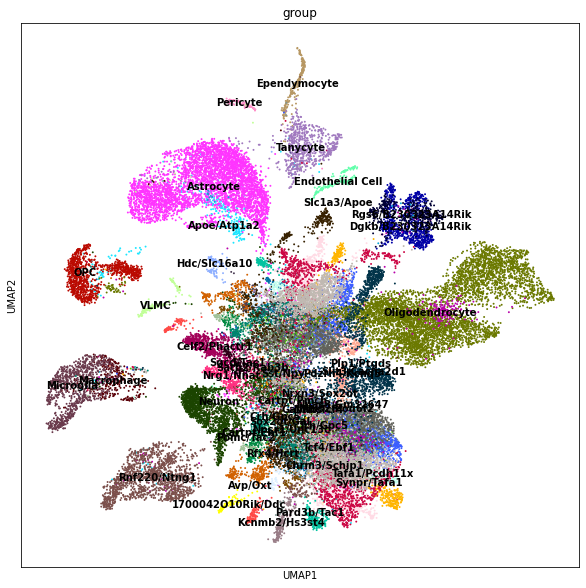

In [31]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['group'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

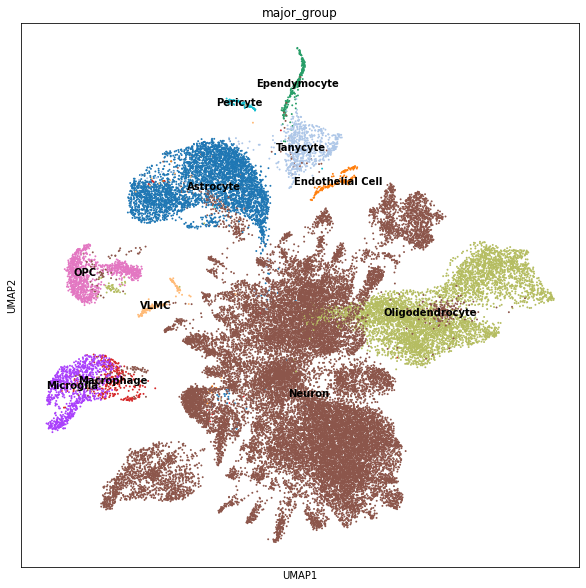

In [32]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['major_group'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

### Brief description of the model

**Model-based estimation of reference expression signatures of cell types $g_{f,g}$ using a regularised Negative Binomial regression.** This model robustly derives reference expression signatures of cell types $g_{f,g}$ using the data composed of multiple batches $e=\{1..E\}$ and technologies $t=\{1..T\}$. Adapting the assumptions of a range of computational methods for scRNA-seq, we assume that the expression count matrix follows a Negative Binomial distribution with unobserved expression levels (rates) $\mu_{c,g}$ and a gene-specific over-dispersion $\alpha_g$. We model $\mu_{c,g}$ as a linear function of reference cell type signatures and technical effects:
- $e_e$ denotes a multiplicative global scaling parameter between experiments/batches $e$ (e.g. differences in sequencing depth);
- $t_{t,g}$ accounts for multiplicative gene-specific difference in sensitivity between technologies; 
- $b_{e,g}$ accounts for additive background shift of each gene in each experiment $e$ (proxy for free-floating RNA).


![Model diagram](../images/Regression_model_diagram.png)  

Also see https://cell2location.readthedocs.io/en/latest/cell2location.regression_models.html#regressiongenebackgroundcoveragegenetechnologytorch

```python
help(cell2location.models.RegressionGeneBackgroundCoverageTorch)
```

### Training the model

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

In [33]:
from cell2location import run_regression

In [34]:
adata_snrna_raw.var = adata_snrna_raw.var.rename(columns={"features":"SYMBOL"})

In [35]:
adata_snrna_raw.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,percent.mt,integrated_snn_res.1.5,seurat_clusters,group,major_group,n_genes
Unnamed: 0,,,,,,,,,,
CCAATCCTCGTTTATC-1_1,Aged_1,1018,762,Aged,0.785855,55,55,1700042O10Rik/Ddc,Neuron,762
CAGTCCTAGTCCATAC-1_1,Aged_1,4352,2203,Aged,0.620404,55,55,1700042O10Rik/Ddc,Neuron,2203
CATGGATGTTGCTGAT-1_4,Aged_4,32357,7259,Aged,0.154526,55,55,1700042O10Rik/Ddc,Neuron,7259
TCTTTCCTCTGCTGCT-1_2,Aged_2,4189,1921,Aged,1.169730,55,55,1700042O10Rik/Ddc,Neuron,1921
TCATGAGTCACGAACT-1_4,Aged_4,23950,5868,Aged,0.083507,55,55,1700042O10Rik/Ddc,Neuron,5868
...,...,...,...,...,...,...,...,...,...,...
TTCATGTAGTAAACTG-1_8,Young_4,3802,2010,Young,2.183062,50,50,VLMC,VLMC,2010
TTTGGTTGTGCGAAAC-1_6,Young_2,1692,1060,Young,1.063830,50,50,VLMC,VLMC,1060
TGCTGCTGTGCAACGA-1_1,Aged_1,1555,958,Aged,1.221865,50,50,VLMC,VLMC,958


### Creating model ### - time 0.03 min
### Analysis name: RegressionGeneBackgroundCoverageTorch_54covariates_40064cells_14795genes
### Training model to determine n_epochs with CV ###


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

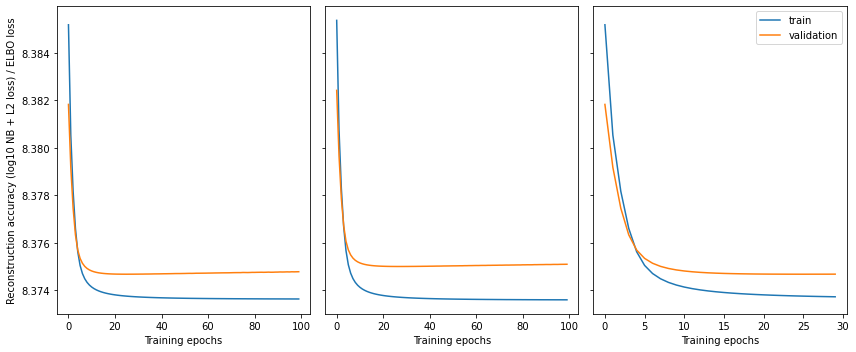

### Re-training model to stop before overfitting ###


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

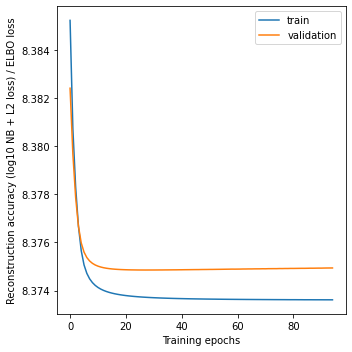

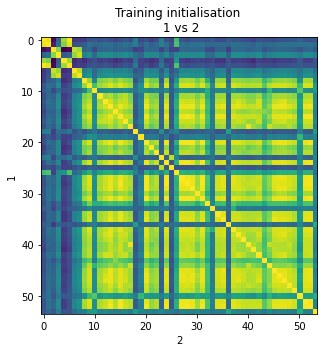

### Evaluating parameters / sampling posterior ### - time 12.06 min


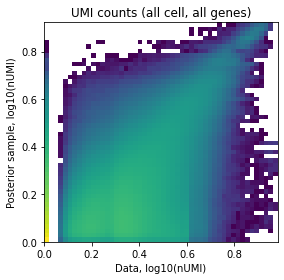

### Saving results ###
### Plotting results ###
Some error in plotting inferred sample_scaling
 Wrong number of dimensions. values.ndim > ndim [2 > 1]


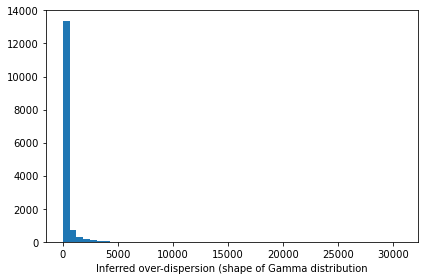

### Done ### - time 13.51 min


In [36]:
r, adata_snrna_raw = run_regression(adata_snrna_raw, # input data object]
                   
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['group'], # column listing cell type annotation
                    'sample_name_col': 'orig.ident', # column listing sample ID for each cell
                    
                    # column listing technology, e.g. 3' vs 5', 
                    # when integrating multiple single cell technologies corresponding 
                    # model is automatically selected
                    'tech_name_col': None, 
                    
                    'stratify_cv': 'group', # stratify cross-validation by cell type annotation
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_cuda': True, # use GPU?
                       
                    'train_proportion': 0.9, # proportion of cells in the training set (for cross-validation)
                    'l2_weight': True,  # uses defaults for the model
                    
                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},
                                 
                   model_kwargs={}, # keep defaults
                   posterior_args={}, # keep defaults
                                 
                   export_args={'path': results_folder + 'regression_model/', # where to save results
                                'save_model': True, # save pytorch model?
                                'run_name_suffix': ''})

reg_mod = r['mod']

Saved anndata object and the trained model object can be read later using:
    
```python
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_54covariates_40064cells_14795genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
## model
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
reg_mod = r['mod']
```

Export reference expression signatures of cell types:

In [37]:
# Export cell type expression signatures:
covariate_col_names = 'group'

inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

Compare estimated signatures (y-axis) to analytically computed mean expression (x-axis):

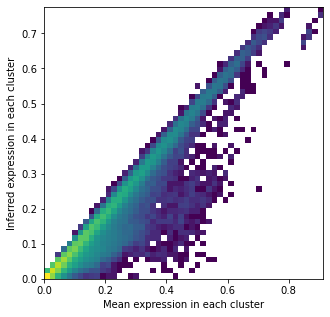

In [38]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, covariate_col_names)
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# compare estimated signatures (y-axis) to analytically computed mean expression (x-axis)
with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=mpl.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

Evaluate whether estimated signatures are less correlated because the confounding sample background is now removed:

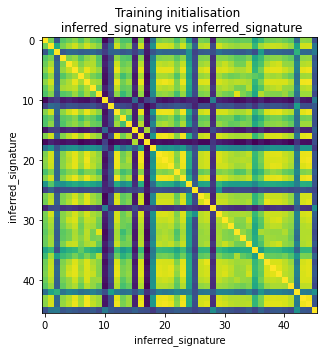

In [39]:
# Look at how correlated are the signatures obtained by computing mean expression
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

# Look at how correlated are the signatures inferred by regression model - they should be less correlated than above
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_signature', 'inferred_signature', align=False)

Compare cell count per experiment to estimated background (soup, free-floating RNA):

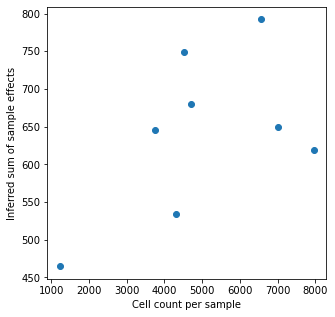

In [40]:
# Examine how many mRNA per cell on average are background 
sample_name_col = 'orig.ident'
cell_count = adata_snrna_raw.obs[sample_name_col].value_counts()
cell_count.index = [f'means_sample_effect{sample_name_col}_{i}' for i in cell_count.index] 
soup_amount = reg_mod.sample_effects.sum(0) 

with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.scatter(cell_count[soup_amount.index].values.flatten(),
                soup_amount.values.flatten());
    plt.xlabel('Cell count per sample'); # fraction of reads in cells
    plt.ylabel('Inferred sum of sample effects');

In [41]:
cell_count

means_sample_effectorig.ident_Aged_2     7957
means_sample_effectorig.ident_Aged_1     7011
means_sample_effectorig.ident_Young_2    6573
means_sample_effectorig.ident_Young_4    4714
means_sample_effectorig.ident_Aged_4     4528
means_sample_effectorig.ident_Aged_3     4312
means_sample_effectorig.ident_Young_3    3740
means_sample_effectorig.ident_Young_1    1229
Name: orig.ident, dtype: int64

Supply reference expression signatures to cell2location model (see next notebook):

```python
# Use `inf_aver` for cell2location mapping:
cell2location.run_cell2location(sc_data=inf_aver, ...)
```

## 5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow <a name="5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow"></a>

This allows to identify if the model successfully accounted for technical factor by checking whether removing contribution those factors from every single cell leads to merging of samples / batches, yet preserves well-separated cell types in the UMAP space.

In [ ]:
adata_snrna_raw_cor = adata_snrna_raw.copy()
del adata_snrna_raw_cor.uns['log1p']

adata_snrna_raw_cor.X = np.array(reg_mod.normalise(adata_snrna_raw_cor.raw.X.copy()))

sc.pp.log1p(adata_snrna_raw_cor)
sc.pp.scale(adata_snrna_raw_cor, max_value=10)
sc.tl.pca(adata_snrna_raw_cor, svd_solver='arpack', n_comps=80, use_highly_variable=False)

adata_snrna_raw.obs['total_counts'] = np.array(adata_snrna_raw.raw.X.sum(1)).flatten()
adata_snrna_raw_cor.obs['total_counts'] = adata_snrna_raw.obs['total_counts']

#sc.pl.pca(adata_snrna_raw_cor, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data', vmax='p99.9',
#          legend_fontsize=10)

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw_cor.obsm['X_pca'] = adata_snrna_raw_cor.obsm['X_pca'][:, 1:]
adata_snrna_raw_cor.varm['PCs'] = adata_snrna_raw_cor.varm['PCs'][:, 1:]

# here we use standard neighbors function rather than bbknn 
# to show that the regression model can merge batches / experiments
sc.pp.neighbors(adata_snrna_raw_cor, n_neighbors = 15, n_pcs = 79, metric='cosine')
sc.tl.umap(adata_snrna_raw_cor, min_dist = 0.8, spread = 1)

In [ ]:
with mpl.rc_context({'figure.figsize': [7, 7],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw_cor, color=["orig.ident", 'stim', 'major_group', 'group'],
               color_map = 'RdPu', ncols = 1, size=13, #legend_loc='on data',
               legend_fontsize=10, palette=sc.pl.palettes.default_102)

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass